In [1]:
import biosteam as bst
import thermosteam as tmo
import biorefineries as bf
from biorefineries import cellulosic
from lignin_saf.reactor import *

In [2]:
tmo.Stream.display_units.N = 20       # Increasing number of display units to see all components of streams 
tmo.MultiStream.display_units.N = 20  

In [3]:
def create_chemicals():


    # copying cellulosic ethanol chemicals 
    chems = cellulosic.create_cellulosic_ethanol_chemicals().copy()

    # Adding pre-existing chemicals
    methanol = tmo.Chemical('Methanol')
    hydrogen = tmo.Chemical('Hydrogen')
    methane = tmo.Chemical('Methane')
    activated_carbon = tmo.Chemical('ActivatedCarbon', search_db=False, default=True, phase='s')

    
    # Custom chemical properties estimated using NIST ThermoDataEngine (TDE) from Aspen Plus V14
    # Only propylguaiacol was native to Aspen, every other component was user defined
    # All six of these user defined components are the same as chosen by Bartling et al Fig S8
    # Constant properties like normal boiling point, critical temp, critical pressure were added
    # Custom models for heat capacity, density as functions of temperatures were NOT included
   
    propylguaiacol = tmo.Chemical(  # S-Lignin Monomer 
        'Propylguaiacol',
        default = True,      # Defaults all other properties 
        search_db=False,     # Since not present in database, do not search
        formula='C10H14O2',  # Chemical formulae
        phase='l',           # phase at rtp
        omega = 0.6411,      # accentric factor
        Tb = 541.7,          # [K]  normal boiling point
        # Tc = 749,            # [K]  critical temperature
        # Pc = 2.9e6,          # [Pa] critical pressure
        Hvap = 7.78e4,       # [J/mol] enthalpy of vaporization at 298 K
        rho = 1056.3,        # [kg/m3] density at rtp

    )
    propylguaiacol.synonyms = ('4-Propylguaiacol',) # Synonyms that can be used to refer to it

    
    propylsyringol = tmo.Chemical(   # G-Lignin Monomer 
        'Propylsyringol',
        default = True,
        search_db=False,
        formula='C11H16O3',
        phase='l',
        omega = 0.87334, 
        Tb = 617.3,      
        #Tc = 819,        
        # Pc = 2565348.3,   
        Hvap = 1.07e5,    
        rho  = 1274.3    
    )
    propylsyringol.synonyms = ('4-Propylsyringol',)

    syringaresinol = tmo.Chemical(  # S-Lignin Dimer 
        'Syringaresinol',
        default = True,
        search_db = False,
        formula = 'C22H26O8',
        phase = 'l',
        omega = 1.4608,
        Tb = 796.7,
        # Tc = 979,
        # Pc = 1.83e6,
        Hvap = 1.99e5,
        rho = 1596.5
    )

    g_dimer = tmo.Chemical(   # Couldn't find a chemical name so going with g_dimer
        'G_Dimer',
        default = True,
        search_db = False,
        MW = 362.42,
        phase = 'l',
        omega = 1.3966,
        Tb = 812.6,
        # Tc = 992,
        # Pc = 1.54e6,
        Hvap = 1.97e5,
        rho = 1497.3
    )

    s_oligomer = tmo.Chemical(
        'S_Oligomer',
        default = True,
        search_db = False,
        MW = 628.67,
        phase = 'l',
        omega = 0.78742,
        Tb = 921.4,
        # Tc = 1128,
        # Pc = 8.27e5
    )  

    g_oligomer = tmo.Chemical(    # Found little to no properties for G_Oligomer
        'G_Oligomer',
        default = True,
        search_db = False,
        MW = 540.65,
        phase = 'l'
    )


    # 4) Extend the base collection
    chems.extend([methanol, hydrogen, methane, activated_carbon, propylguaiacol, propylsyringol,syringaresinol,g_dimer,
                  s_oligomer, g_oligomer])

    chems.compile()  # Compiling all the chemicals to one string
    return chems


chems = create_chemicals()
bst.settings.set_thermo(chems) # Setting thermodynamic property pacakge for the chemicals


In [4]:
bst.settings.CEPCI = 541.7   # CEPCI for 2016, set to same as Bartling paper

In [5]:
# Defining poplar group based off composition given in Bartling et al Table S1

chems.define_group(
    name='Poplar',
    IDs=['Cellulose',   # Cellulase break this down to glucose
         'Xylan',       # Hemicellulose
         'Arabinan',    # Hemicellulose
         'Mannan',      # Hemicellulose
         'Galactan',    # Hemicellulose
         'Sucrose',   
         'Lignin',
         'Acetate',
         'Extract',     # Non structural component of biomass that dissolves in solvent/water 
         'Ash'],
    composition=[0.464,      # Dry wt composition, feed also has 20 wt% moisture content
                 0.134,
                 0.002,
                 0.037,
                 0.014,
                 0.001,
                 0.285,
                 0.035,
                 0.016,
                 0.012],
    wt=True
)


In [6]:
# Process conditions from Bartling et al 2021 unless specified otherwise


# Feed
biomass_flow = 2000                   # [dry metric tons per day], consistent with other TEA models 
biomass_moisture  = 0.2               # [%] 20% moisture

# RCF
rcf_temp = 200 + 273.15            # [K]
rcf_pressure = 60 * 1e5            # [bar]
solvolysis_tau = 2                 # [hr] residence time
hydrogenolysis_tau = 1             # [hr] residence time
meoh_h2o = 9                       # [ratio] Solvent : Water ratio
delignification = 0.7              # [%] 70% biomass delignified
methanol_decomp = 0.005            # [%] methanol decomposition rate (loss of solvent due to conversion into carbonaceous gases)

methanol_to_ch4 = 0.128/100        # [wt%] methanol lost as CH4. From https://pubs.rsc.org/en/content/articlelanding/2015/cc/c5cc04025f Table 1 where 0.08 mol% of methanol lost as CH4 for Ru/C catalyst
                                   # reactor was batch and hydrogen was fed at 3 MPa within the reactor, also biomass was birchwood so this might be different in my case

methanol_to_co = 0.364/100         # [wt%] methanol lost as CH4. From https://pubs.rsc.org/en/content/articlelanding/2015/cc/c5cc04025f Table 1 where 0.13 mol% of methanol lost as CH4 for Ru/C catalyst
                                   # reactor was batch and hydrogen was fed at 3 MPa within the reactor, also biomass was birchwood, so this might be different in my case

h2_consumption = 0.05        # 5% of hydrogen consumed in hydrogenolysis. Completely assumed value for now

cellulose_retention = 0.9          # [%] 90% cellulose retained in biomass pulp after RCF
xylose_retention = 0.93            # [%] 93% xylose retained in biomass pulp after RCF
extractives_retention = 0          # [%] extractives retention in biomass from 10.1039/d1gc01591e Table S1 (no extractives in post-solvolysis poplar)
                                   # Also validated from SI Table S17 of Bartling et al where extractives total amount (kg) in RCF oil is similar to what is in the poplar feed 
acetate_retention = 0              # [%] acetate retention in biomass from 10.1039/d1gc01591e Table S1 (no acetate in post-solvolysis poplar)
cat_replace = 1                    # [/yr] catalyst replacement rate
methanol_to_biomass = 9            # [L/kg] from https://doi.org/10.1016/j.copbio.2018.12.005
                                   # Surprisingly, Bartling et al assumes a 9L/kg for a flow through
                                   # configuration which is very less.
hydrogen_amount = 10               # 10 L/min/dry kg biomass
catalyst_loading = 0.1             # 1:10 catalyst: dry biomass feed by wt 
catalyst_cost = 37.5               # USD/kg from Bartling et al.

# RCF oil composition
lignin_monomers = 0.5
lignin_dimers = 0.25
lignin_oligomers = 0.25 





In [7]:
poplar_in = bst.MultiStream('Poplar_In',
                s=[('Poplar', biomass_flow*1e3)], l=[('Water', biomass_moisture*biomass_flow*1e3)], 
                 phases = ('s','l'), units='kg/d')



In [8]:
meoh_in = bst.Stream('meoh_in',
                    Methanol =  (methanol_to_biomass*biomass_flow*1e3*0.9),
                    Water =  methanol_to_biomass*biomass_flow*1e3*(1/meoh_h2o)*0.9,
                     phase = 'l',   
                     units = 'L/d')

# Set as a MultiStream to make it easier later on as this stream will also contain carbohydrate
# derivatives (solids) following solvolysis and hydrogen (gas) following hydrogenolysis

# both flows multipled by 0.9 to make the overall meoh_in to biomass liter to kg ratio as 90 which is a requirement

In [9]:
meoh_recycle = bst.MultiStream('meoh_recycle', phases = ('s','l','g'))

In [10]:
meoh_h2o_mix = bst.units.Mixer(ins = (meoh_in, meoh_recycle), rigorous = True)
@meoh_h2o_mix.add_specification(run = True)
def meoh_water_flow():
    fresh_solvent = meoh_h2o_mix.ins[0]
    recycle_solvent = meoh_h2o_mix.ins[1]

    meoh_flow_mol  = (((methanol_to_biomass*biomass_flow*1e3*0.9)/1000)/24) * chems['Methanol'].rho(phase = 'l', T = 298.15, P = 101325)  * (1/chems['Methanol'].MW)  # Converting flow from L/day to kmol/hr
    fresh_solvent.imol['Methanol'] = meoh_flow_mol - recycle_solvent.imol['Methanol']

    water_flow_mol = ((methanol_to_biomass*biomass_flow*1e3*(1/meoh_h2o)*0.9)/1000/24) * chems['Water'].rho(phase = 'l', T = 298.15, P = 101325)  * (1/chems['Water'].MW) 
    fresh_solvent.imol['Water'] = water_flow_mol - recycle_solvent.imol['Water']
meoh_h2o_mix.simulate()
meoh_h2o_mix.outs[0].phases = ('s','l','g')  # These phases must be available for solvolysis and hydrogenolysis reactors downstream

In [11]:
'''
# Checks to ensure the correct methanol to biomass and methanol to water ratio is used
meoh_biomass_check = round((meoh_in.F_vol*1000)/(2e6/24),0)
methanol_water_check = round(meoh_in.ivol['Methanol']/meoh_in.ivol['Water'],0)

if meoh_biomass_check == methanol_to_biomass:
    print('Correct methanol to biomass ratio')

else:
    raise ValueError(f'Methanol to biomass ratio is {meoh_biomass_check} L/kg dry biomass \n It must be {methanol_to_biomass} L/kg dry biomass as specified')

if methanol_water_check == meoh_h2o:
    print('Correct methanol water ratio')

else:
    raise ValueError(f'Methanol water ratio is {methanol_water_check} \n It must be {meoh_h2o}')
'''

"\n# Checks to ensure the correct methanol to biomass and methanol to water ratio is used\nmeoh_biomass_check = round((meoh_in.F_vol*1000)/(2e6/24),0)\nmethanol_water_check = round(meoh_in.ivol['Methanol']/meoh_in.ivol['Water'],0)\n\nif meoh_biomass_check == methanol_to_biomass:\n    print('Correct methanol to biomass ratio')\n\nelse:\n    raise ValueError(f'Methanol to biomass ratio is {meoh_biomass_check} L/kg dry biomass \n It must be {methanol_to_biomass} L/kg dry biomass as specified')\n\nif methanol_water_check == meoh_h2o:\n    print('Correct methanol water ratio')\n\nelse:\n    raise ValueError(f'Methanol water ratio is {methanol_water_check} \n It must be {meoh_h2o}')\n"

In [12]:
meoh_pump = bst.units.Pump(ins = meoh_h2o_mix-0, P = rcf_pressure)
meoh_heater = bst.units.HXutility(ins = meoh_pump-0, T = rcf_temp, rigorous = True)
meoh_pump.simulate()
meoh_heater.simulate()
meoh_heater.outs[0].phases = ('s','l','g')  # These phases must be available for solvolysis and hydrogenolysis reactors downstream

In [13]:

# Solvolysis reaction to solubilize lignin from cell wall
solvolysis_rxn = bst.Reaction('Lignin,s -> SolubleLignin,l', reactant = 'Lignin', phases = 'sl', X = 0.7, basis = 'wt', correct_atomic_balance = False) 
# correct atomic balance set to False because we are working with pseudocomponents


# Methanol decomposition to light gases
methanol_decomposition_rxn = bst.ParallelReaction([
    bst.Reaction('Methanol,l -> Methane,g', reactant = 'Methanol', phases = 'slg', X = methanol_to_ch4 ,basis = 'wt', correct_atomic_balance=False),
    bst.Reaction('Methanol,l -> CO,g', reactant = 'Methanol', phases = 'slg', X= methanol_to_co, basis = 'wt', correct_atomic_balance=False)
])


In [14]:
"""
References
-----------
    [1] Bartling, Andrew W., et al. 
    "Techno-economic analysis and life cycle assessment of a biorefinery utilizing
    reductive catalytic fractionation." Energy & Environmental Science 14.8 (2021): 4147-4168.

    [2] Anderson, Eric M., et al. 
    "Flowthrough reductive catalytic fractionation of biomass." Joule 1.3 (2017): 613-622.

    [3] Froment, Gilbert F., Kenneth B. Bischoff, and Juray De Wilde. 
    Chemical reactor analysis and design. Vol. 2. New York: Wiley, 1990.
-----------
"""

import biosteam as bst, numpy as np

from typing import Optional
from biosteam.units.design_tools import (
    PressureVessel, 
)
 


__all__ = (
    'SolvolysisReactor', 'RCF1'
    )

class SolvolysisReactor(bst.Unit, bst.units.design_tools.PressureVessel):

    """
    Plug flow reactor for solvolysis reaction, where a solvent is used to solubilize lignin present
    in plant cell wall
    

    In reality, lignin will also be partially depolymerized, but this phenomena is not captured in 
    current design but may be included in a future implementation
    Design based off [1],[2]. Pressure drop calculations from [3]

    By default,  current design supports 3 identical biomass beds, with 2 operational beds at any given time, 
    offset by 1 hour each. With a 3 hr reaction time + 1 hr turnaround, this gives near continuous throughput
    Example... t = 0 - 1 hr : bed 1, bed 2 online, bed 3 cleaning, 
                t = 1 - 2 hr, bed 2, bed 3 online, bed 1 cleaning
    Since at any given time, the complete throughput is mantained by 2 reactors, the total volumetric flow rate 
    of solvent is constant

    
    Assumed: Extraction efficiency constant along the reaction residence time
    No energy released on extraction of lignin. Although this assumption might be revised in the future
    """



 

    auxiliary_unit_names = (
        'pump_1', 'heat_exchanger_1'
    )

    _N_ins = 2
    _N_outs = 2
    
    _units = {**PressureVessel._units,
              'Pressure drop': 'bar',
              'Batch time': 'hr',
              'Turnaround time': 'hr',
              'Residence time': 'hr',
              '# of beds online': "",
              '# of beds in service': "",
              'Total volume': 'm3',
              'Reactor volume': 'm3'}
    


    # Default operating temperature [K]
    T_default: float = 463.15                   # 190 C from  https://doi.org/10.1016/j.joule.2017.10.004

    #: Default operating pressure [Pa]
    P_default:  float = 6e6                     # 6 MPa from https://doi.org/10.1016/j.joule.2017.10.004
    
    #: Default residence time [hr]
    tau_default: float = 2                      # Total 3 hr RCF reaction time divided into 2:1 since solvolysis is more kinetically limiting according to https://pubs.acs.org/doi/full/10.1021/acssuschemeng.8b01256

    #: Default cleaning and unloading time (hr).
    tau_0_default: float  = 1                    # from https://doi.org/10.1039/D1EE01642C
    
    # Default superficial velocity of solvent (m/s)
    superficial_velocity_default: float = 1      # Just assumed 

    # Default methanol decomposition (%)
    methanol_decomposition_default: float = 0.005 # From https://doi.org/10.1039/D1EE01642C

    # Default poplar bed void fraction (epsilon)
    void_frac_default: float = 0.5                # Just assumed here, can be fine tuned once data is known. Assyned because this value gives a low value for pressure drop


    # Default working volume fraction 
    working_vol_default: float = 0.8              # Just assumed based off engineering judgement
 
    # Default poplar diameter [m]
    poplar_diameter_default: float = 0.004        # https://doi.org/10.1039/D1EE01642C mentions < 5mm, Here 4 mm is considered
    



    def _init(
            self,
            T: Optional[float] = None, 
            P: Optional[float] = None,
            tau: Optional[float] = None,
            vessel_material: Optional[str] = None,
            vessel_type: Optional[str] = None,
            tau_0: Optional[float] = None,  
            superficial_velocity: Optional[float] = None,
            methanol_decomposition: Optional[float] = None,
            void_frac: Optional[float] = None,
            working_vol: Optional[float] = None,
            poplar_diameter: Optional[float] = None,
            N_beds = 6, 
            *,
            reaction_1,
            reaction_2
            ):
        
        
        self.T = self.T_default if T is None else T
        self.P = self.P_default if P is None else P
        self.tau = self.tau_default if tau is None else tau
        self.vessel_material = 'Stainless steel 316' if vessel_material is None else vessel_material
        self.vessel_type = 'Vertical' if vessel_type is None else vessel_type
        self.tau_0 = self.tau_0_default if tau_0 is None else tau_0
        self.superficial_velocity = self.superficial_velocity_default if superficial_velocity is None else superficial_velocity
        self.methanol_decomposition = self.methanol_decomposition_default if methanol_decomposition is None else methanol_decomposition
        self.void_frac = self.void_frac_default if void_frac is None else void_frac
        self.working_vol = self.working_vol_default if working_vol is None else working_vol
        self.poplar_diameter = self.poplar_diameter_default if poplar_diameter is None else poplar_diameter
        if N_beds != 6:
            raise ValueError('only 6 biomass beds are valid')
        self.reaction_1 = reaction_1
        self.reaction_2 = reaction_2
        self.N_beds = N_beds
        pump_1 = self.auxiliary('pump_1', bst.Pump, ins = self.ins[1])
        # heat_exchanger_1 = self.auxiliary('heat_exchanger_1', bst.HXutility, pump_1.outs[0])


    def _size_bed(self):
        
        #### Reactor volume sizing ########

        cycle_time = self.tau + self.tau_0    # Total time for a cycle of operation (includes reaction + cleaning-loading-unloading)
        occupied_frac = 1 - self.void_frac    # ratio of occupied biomass fraction/total biomass bed
        working_vol = self.working_vol        # Working volume fraction for a reactor to allow suficient mass transfer by allowing enough contact time 
        solvent = self.ins[1]


        
        liquid_V_w = solvent.F_vol * cycle_time   # [m3] Total liquid working volume
        liquid_V_w_pr = liquid_V_w/self.N_beds    # [m3] Liquid working volume per reactor 
        V_actual = liquid_V_w_pr/(self.void_frac * working_vol)  # [m3]    void frac = vol. of solvent/total bed vol.
        total_volume = V_actual * self.N_beds

        ##### Reactor diameter and length ########
        u  = self.superficial_velocity                   # [m/s]
        N_operating = self.N_beds *(self.tau/cycle_time) # Number of beds operating at any given time
        Q_per_reactor_m3 = solvent.F_vol/N_operating     # [m3/hr] Volumetric flow rate processed by any reactor
        self.area = A  = Q_per_reactor_m3/(u*3600)
        self.diameter = diameter = 2 * (A/np.pi) ** 0.5
        self.length = length = V_actual/A

        
        return length, diameter, V_actual, total_volume        

        
    def _run(self):
        biomass, solvent = self.ins
        used_biomass, used_solvent = self.outs

        used_solvent.copy_like(solvent) 
        used_biomass.copy_like(biomass) 

        used_solvent.P = self.P                  # Outlet pressure is set to reactor pressure. Inlet pressure will be greater to account for pressure drop
        used_solvent.T = self.T                  # Since isothermal operation
        

        self.reaction_1(used_biomass) 
        self.reaction_2(used_solvent)
        

        solubilized_lignin = used_biomass.imass['SolubleLignin'] 
        used_solvent.imass['l', 'SolubleLignin'] += solubilized_lignin # Soluble lignin dissolves in solvent effluent stream 
        used_biomass.imass['l', 'SolubleLignin'] = 0 # No soluble lignin remaining in biomass (assuming 100% extraction efficiency)



        extractives = used_biomass.imass['Extract']     # From Table S1 https://www.rsc.org/suppdata/d1/gc/d1gc01591e/d1gc01591e1.pdf,
                                                        # it follows that the extractives component of poplar is 'extracted' in the solvent stream
        used_solvent.imass['l', 'Extract'] = (1-extractives_retention)*extractives
        used_biomass.imass['s', 'Extract'] = (extractives_retention)*extractives

        acetate = used_biomass.imass['s', 'Acetate']
        used_solvent.imass['l', 'Acetate'] =  acetate *(1-acetate_retention)  # Assuming acetate dissolves as acetic acid with methanol,
                                                                              # BioSTEAM Chemicals assumes same properties for acetic acid and acetate, otherwise is acetate was a pseudocomponent, it might have still stayed in solid phase
        used_biomass.imass['s', 'Acetate'] = acetate*acetate_retention


        cellulose_mass = used_biomass.imass['s', 'Cellulose']
        used_solvent.imass['l', 'Cellulose'] = cellulose_mass*(1-cellulose_retention) # Dissolved cellulose assumed to be in liquid phase as solution with solvent
        used_biomass.imass['s', 'Cellulose'] =  cellulose_mass*cellulose_retention
                                                               

        xylose_mass = used_biomass.imass['s', 'Xylose']
        used_solvent.imass['l', 'Xylose'] = xylose_mass * (1-xylose_retention) # Dissolved xylose assumed to be  liquid phase as solution with solvent
        used_biomass.imass['s', 'Xylose'] = xylose_mass * xylose_retention
        

        # The temperature and pressure of the carbohydrate pulp is not changed here, because I don't know its fate yet
        



    def _calculate_pressure_drop(self, bed_length):

        D = self.poplar_diameter # [m] poplar particle diameter
        rho = self.outs[1].rho  # [kg/m3] 
        mu = self.outs[1].get_property('mu', 'kg/m/s') # [Pa s] methanol water viscosity 
        epsilon = self.void_frac # Void fraction 
        u = self.superficial_velocity # [m/s] superficial velocity  

        
        
        Re = (D*rho*u)/mu
        if Re/(1-epsilon) < 500: # Erun equation
            f = ((1-epsilon)/(epsilon**3))*(1.75+(150*(1-epsilon)/Re))
            dP = (f * ((rho*(u**2))/D)* bed_length)*1e-5             # [bar] 1e-5 converts Pa to bar
        elif 1000 < Re/(1-epsilon) < 5000: # Handley and Heggs
            f = ((1-epsilon)/(epsilon**3))*(1.24+(368*(1-epsilon)/Re))
            dP = (f * ((rho*(u**2))/D)* bed_length)*1e-5
        else: # Hicks equation which fits in Wentz and Thodos results for very high Re
            f = 6.8*(((1-epsilon)**1.2)/epsilon**3)*Re**-0.2
            dP = (f * ((rho*(u**2))/D) * bed_length)*1e-5
        return dP

        

    def _design(self):
        length, diameter, V_actual, total_volume = self._size_bed()   # Calling size bed function to determine diameter and length 
        cycle_time = self.tau + self.tau_0

        self.set_design_result('Diameter', 'ft', diameter)  
        self.set_design_result('Length', 'ft', length)
        self.set_design_result('Reactor volume', 'm3', V_actual)
        self.set_design_result('Total volume', 'm3', total_volume)
        self.set_design_result('Residence time', 'hr', self.tau)
        self.set_design_result('Turnaround time', 'hr', self.tau_0)
        self.set_design_result('Batch time', 'hr', cycle_time)


        
        # Calculates weight based off pressure, diameter and length
        # Adds vcessel type wall thickness, vessel weight, diameter and length to dictionary
        # But diameter and length are already there because of set_design_result above
        
        self.design_results.update(
            self._vertical_vessel_design(    
                self.P*(1/6894.76),
                self.design_results['Diameter']*3.28084,
                self.design_results['Length']*3.28084
            )
        )
        
                            

        pressure_drop = self._calculate_pressure_drop(length)                  
        
        self.set_design_result('Pressure drop', 'bar', pressure_drop)
        self.pump_1.P = (self.P - self.ins[1].P) + (pressure_drop*1e5)
        self.pump_1.simulate()








    def _cost(self):
        design = self.design_results # Calling the dictionary used to store design results in design method above 

        baseline_purchase_costs = self.baseline_purchase_costs # Dictionary for storing baseline costs

        weight = design['Weight']  # weight parameter stores the value from the 'Weight' key in the design dictionnary

        # Calculates the baseline purchase cost based off diameter length and weight
        baseline_purchase_costs.update( 
            self._vessel_purchase_cost(weight, design['Diameter'], design['Length'])
        )

        self.parallel['self'] = self.N_beds # Used to create multiple of the same beds
        self.parallel['pump_1'] = 1 # Just one pump needed, valves will redirect to whichever bed is online


        
       
        """
        ---------
          
        - Might need to alter data on working volume, void fraction of poplar, poplar particle size,
        for more realistic modeling

        ----------

        """



        

        


In [15]:
## Independent pressure drop calculator for verifying purposes

D = 0.0037                   # [m] poplar particle diameter
rho = 0.9487                   # [kg/m3] 
mu = 3.1e-5             # [Pa s] methanol water viscosity 
epsilon = 0.38               # void fraction 
u = 1.37                     # [m/s] superficial velocity  

bed_length = 2.5

Re = (D*rho*u)/mu
if Re/(1-epsilon) < 500: # Erun equation
    f = ((1-epsilon)/(epsilon**3))*(1.75+(150*(1-epsilon)/Re))
    dP = (f * ((rho*(u**2))/D)* bed_length)*1e-5
elif 1000 < Re/(1-epsilon) < 5000: # Handley and Heggs
    f = ((1-epsilon)/(epsilon**3))*(1.24+(368*(1-epsilon)/Re))
    dP = (f * ((rho*(u**2))/D)* bed_length)*1e-5
else: # Hicks equation which fits in Wentz and Thodos results for very high Re
    f = 6.8*(((1-epsilon)**1.2)/epsilon**3)*Re**-0.2
    dP = (f * ((rho*(u**2))/D) * bed_length)*1e-5
print(f'Pressure drop is {0.319} bar')



Pressure drop is 0.319 bar


In [16]:
# Created as a check to see if logic inside the solvolysis reactor class is working
N_beds = 6
tau = 2
cycle_time = 3
N_operating  = 4
u = 0.003
void_frac = 0.5
working_vol = 0.8

total_sol_V = meoh_in.F_vol * cycle_time         # [m3]
total_sol_V_per_reactor = total_sol_V/N_beds   # [m3]
actual_V_per_reactor = total_sol_V_per_reactor/(void_frac*working_vol)

N_operating = N_beds *(tau/cycle_time) # Number of beds operating at any given time
Q_per_reactor_m3 = meoh_in.F_vol/N_operating     # [m3/hr] Volumetric flow rate processed by any reactor
A  = Q_per_reactor_m3/(u*3600)                   # [m2]
diameter = 2 * (A/np.pi) ** 0.5                  # [m]
length = actual_V_per_reactor/A                  # [m]

print(f'Actual reactor volume is: {actual_V_per_reactor} m3')

Actual reactor volume is: 937.5 m3


In [17]:
solvolysis_reactor = SolvolysisReactor(ins = (poplar_in, meoh_heater-0), outs = ('Carbohydrate_Pulp', 'Solvolysis_Liquor'),
                                    T = rcf_temp,
                                    P = rcf_pressure,
                                    tau = solvolysis_tau, 
                                    N_beds = 6,
                                    void_frac= 0.5,
                                    superficial_velocity = 0.001, 
                                    reaction_1 = solvolysis_rxn,
                                    reaction_2 = methanol_decomposition_rxn
                                    )
solvolysis_reactor.simulate()

# Yes, some of the bounds exceed the limits, but its primarily due to high solvent loadings in 
# the solvolysis reactor

C:\Users\hwadg\AppData\Local\Temp\ipykernel_31008\2942498893.py:264: CostWarning: <SolvolysisReactor: R1> Vertical vessel weight (5.237e+06 lb) is out of bounds (4200 to 1e+06 lb) for cost correlation
  self._vertical_vessel_design(
C:\Users\hwadg\AppData\Local\Temp\ipykernel_31008\2942498893.py:264: CostWarning: <SolvolysisReactor: R1> Vertical vessel length (59.06 ft) is out of bounds (12 to 40 ft) for cost correlation
  self._vertical_vessel_design(
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\_unit.py:986: RuntimeWarning: the purchase cost item, 'Vertical pressure vessel', has no defined bare-module factor in the 'SolvolysisReactor.F_BM' dictionary; bare-module factor now has a default value of 1
  warn(f"the purchase cost item, '{name}', has "
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\_unit.py:986: RuntimeWarning: the purchase cost item, 'Platform and ladders', has no defined bare-module factor in the 'SolvolysisReactor.F_BM' dictionary; ba

In [18]:
solvolysis_reactor

SolvolysisReactor: R1
ins...
[0] Poplar_In  
    phases: ('l', 's'), T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): (l) Water      925
                    (s) Sucrose    0.243
                        Extract    7.4
                        Acetate    48.6
                        Ash        1e+03
                        Lignin     156
                        Cellulose  238
                        Xylan      84.5
                        Arabinan   1.26
                        Mannan     19
                        Galactan   7.2
[1] s3  from  HXutility-H1
    phases: ('g', 'l', 's'), T: 473.15 K, P: 6e+06 Pa
    flow (kmol/hr): (l) Water     4.15e+03
                        Methanol  1.66e+04
outs...
[0] Carbohydrate_Pulp  
    phases: ('l', 's'), T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): (l) Water      925
                    (s) Sucrose    0.243
                        Ash        1e+03
                        Lignin     46.8
                        Cellulose  215
                     

In [19]:
solvolysis_reactor.results()

Solvolysis reactor                                  Units        R1
Electricity         Power                              kW      36.8
                    Cost                           USD/hr      2.88
Design              Diameter                           ft      30.9
                    Length                             ft      59.1
                    Reactor volume                     m3  1.25e+03
                    Total volume                       m3  7.51e+03
                    Residence time                     hr         2
                    Turnaround time                    hr         1
                    Batch time                         hr         3
                    Vessel type                            Vertical
                    Weight                             lb  5.24e+06
                    Wall thickness                     in      14.4
                    Pressure drop                     bar  0.000526
Purchase cost       Vertical pressure vessel (x6)     USD  6.24e+07
                    Platform and ladders (x6)         USD  5.31e+05
                    Pump 1 - Pump (x6)                USD  3.04e+04
                    Pump 1 - Motor (x6)               USD  2.06e+03
Total purchase cost                                   USD   6.3e+07
Utility cost                                       USD/hr      2.88

In [20]:
carbohydrate_derivates  = ((solvolysis_reactor.outs[1].imass['Acetate']
  + solvolysis_reactor.outs[1].imass['Cellulose'] + solvolysis_reactor.outs[1].imass['Xylan'])*24*330)/1e6

print(f'Carbohydrate derivates in solvent due to dissolution constitute {carbohydrate_derivates} MMkg/yr \n In Bartling et al, it is 54.2 MM kg/yr')

Carbohydrate derivates in solvent due to dissolution constitute 53.724 MMkg/yr 
 In Bartling et al, it is 54.2 MM kg/yr


In [21]:
hydrogen_in = bst.Stream('Hydrogen_In', 
                         Hydrogen = (10)*(2e6/24/60),   # Anderson et al, had MeOH/H2 feeds as 1:100 vol:vol ratio
                         units = 'L/min',
                         T = 80+273.15,                   # 80 C outlet temperature of PEM electrolysis
                         P = 3e6,                         # 30 bar outlet pressure of H2 through PEM electrolysis
                         phase = 'g'
)



In [22]:
hydrogen_recycle = bst.Stream('hydrogen_recycle', P = 3e6, phase = 'g')
# hydrogen_fresh = bst.Stream('hydrogen_fresh', T = 473.15, P = 3e6, phase = 'g' )

In [23]:
#h2_heater = bst.units.HXutility(ins = hydrogen_in, T = 473.15, rigorous = True )
# h2_heater.simulate()
# hydrogen_fresh.phase = 'g'

In [24]:
h2_mixer = bst.units.Mixer(ins = (hydrogen_in, hydrogen_recycle))
@h2_mixer.add_specification(run = True)
def h2_flow():
    fresh_h2 = h2_mixer.ins[0]
    recycle_h2 = h2_mixer.ins[1]

    h2_flow = (10)*(2e6/24/60) * (60/1000) * (chems['Hydrogen'].rho(phase = 'g', T = rcf_temp, P = 3e6)) * (1/chems['Hydrogen'].MW)
    fresh_h2.imol['Hydrogen'] = h2_flow - recycle_h2.imol['Hydrogen']

h2_mixer.simulate()


In [25]:
h2_pre_heat = bst.units.HXutility(ins = h2_mixer-0, T = rcf_temp, rigorous = True)
h2_pre_heat.simulate()


In [26]:
chems['Hydrogen'].rho(T = 4.15, P = 1e6, phase = 'g')

0.0004995845346753258

In [27]:
hydrogenolysis = bst.ParallelReaction([
    bst.Reaction('SolubleLignin,l ->Propylguaiacol,l', reactant = 'SolubleLignin', phases = 'slg', X = 0.25, basis = 'wt', correct_atomic_balance=False),
    bst.Reaction('SolubleLignin,l ->Propylsyringol,l', reactant = 'SolubleLignin', phases = 'slg', X = 0.25, basis = 'wt', correct_atomic_balance=False),
    bst.Reaction('SolubleLignin,l -> Syringaresinol,l', reactant= 'SolubleLignin',phases = 'slg', X = 0.125, basis = 'wt', correct_atomic_balance=False),
    bst.Reaction('SolubleLignin,l -> G_Dimer,l', reactant= 'SolubleLignin', phases = 'slg',X = 0.125, basis = 'wt', correct_atomic_balance=False),
    bst.Reaction('SolubleLignin,l -> S_Oligomer,l', reactant= 'SolubleLignin',phases = 'slg', X = 0.125, basis = 'wt', correct_atomic_balance=False),
    bst.Reaction('SolubleLignin,l -> G_Oligomer,l', reactant= 'SolubleLignin', phases = 'slg',X = 0.125, basis = 'wt', correct_atomic_balance=False),
])

In [28]:
import biosteam as bst, numpy as np

from typing import Optional
from biosteam.units.design_tools import (
    PressureVessel, 
)
 


__all__ = (
    'HydrogenolysisReactor', 'RCF2'
    )

class HydrogenolysisReactor(bst.Unit, bst.units.design_tools.PressureVessel):


    #auxiliary_unit_names = (
    #    'heat_exchanger_2'
    #)

    _N_ins = 2
    _N_outs = 1
    
    _units = {**PressureVessel._units,
              # 'Pressure drop': 'bar',
              'Residence time': 'hr',
              'Reactor volume': 'm3',
              'Catalyst loading cost': 'USD'}
    


    # Default operating temperature [K]
    T_default: float = 463.15  # 190 C from  https://doi.org/10.1016/j.joule.2017.10.004

    #: Default operating pressure [Pa]
    P_default:  float = 6e6 # 6 MPa from https://doi.org/10.1016/j.joule.2017.10.004
    
    #: Default residence time [hr]
    tau_default: float = 3

    # Default superficial velocity of solvent (m/s)
    superficial_velocity_default: float = 1 # Just assumed 

    # Default catalyst bed void fraction (epsilon)
    void_frac_default: float = 0.3    


    # Default working volume fraction 
    working_vol_default: float = 0.8
 
    # Default catayyst diameter [m]
    # poplar_diameter_default: float = 0.004   
    



    def _init(
            self,
            T: Optional[float] = None, 
            P: Optional[float] = None,
            tau: Optional[float] = None,
            vessel_material: Optional[str] = None,
            vessel_type: Optional[str] = None,
            superficial_velocity: Optional[float] = None,
            void_frac: Optional[float] = None,
            working_vol: Optional[float] = None,
            *,
            reaction
            ):
        
        
        self.T = self.T_default if T is None else T
        self.P = self.P_default if P is None else P
        self.tau = self.tau_default if tau is None else tau
        self.vessel_material = 'Stainless steel 316' if vessel_material is None else vessel_material
        self.vessel_type = 'Vertical' if vessel_type is None else vessel_type
        self.superficial_velocity = self.superficial_velocity_default if superficial_velocity is None else superficial_velocity
        self.void_frac = self.void_frac_default if void_frac is None else void_frac
        self.working_vol = self.working_vol_default if working_vol is None else working_vol
        self.reaction = reaction
        #pump_1 = self.auxiliary('pump_1', bst.Pump, ins = self.ins[1])
        heat_exchanger_2 = self.auxiliary('heat_exchanger_2', bst.HXutility)


    def _size_bed(self):

        #### Reactor volume sizing ########

        residence_time = self.tau
        occupied_frac = 1 - self.void_frac  
        working_vol = self.working_vol        
        influent = self.ins[0]
        liquid_V_w = influent.F_vol * residence_time # [m3] Total liquid working volume
        V_actual = liquid_V_w/(occupied_frac * working_vol)  # [m3]

        ##### Reactor diameter and length ########
        u  = self.superficial_velocity

        Q_per_reactor_m3 = influent.F_vol    # [m3/hr] Volumetric flow rate processed by any reactor
        self.area = A  = Q_per_reactor_m3/u
        self.diameter = diameter = 2 * (A/np.pi) ** 0.5
        self.length = length = V_actual/A

        
        return length, diameter, V_actual
        
    def _run(self):
        solvent, hydrogen = self.ins
        effluent, = self.outs

        

        effluent.copy_like(solvent)
        self.reaction(effluent)

        h2 = hydrogen.imass['Hydrogen'] 

        effluent.imass['g', 'Hydrogen'] = h2*(1-h2_consumption) # 5 % h2 consumption

        effluent.T = self.T # Assuming isothermal operation
        effluent.P = self.P # Assuming no P drop




    #def _calculate_pressure_drop(self):
        # NOT OPERATIONAL FOR HYDROGENOLYSIS REACTOR

        #D = self.poplar_diameter # [m] poplar particle diameter
        #rho_solv = self.ins[1].rho  # [kg/m3] methanol water density
        #mu = self.ins[1].get_property('mu', 'kg/m/s') # [Pa s] methanol water viscosity 
        #epsilon = self.void_frac # Void fraction 
        #u = self.superficial_velocity # [m/s] superficial velocity          
        
        #Re = (D*rho_solv*u)/mu
        #if Re/(1-epsilon) < 500: # Erun equation
        #    dP = ((1-epsilon)/(epsilon**3))*(1.75+(150*(1-epsilon)/Re))
        #elif 1000 < Re/(1-epsilon) < 5000: # Handley and Heggs
        #    dP = ((1-epsilon)/(epsilon**3))*(1.24+(368*(1-epsilon)/Re))
        #else: # Hicks equation which fits in Wentz and Thodos results for very high Re
        #    dP = 6.8*(((1-epsilon)**1.2)/epsilon**3)*Re**-0.2
        #return dP

        

    def _design(self):
        diameter, length, V_actual = self._size_bed()   # Calling size bed function to determine diameter and length 


        self.set_design_result('Diameter', 'ft', diameter)  
        self.set_design_result('Length', 'ft', length)
        self.set_design_result('Reactor volume', 'm3', V_actual)
        self.set_design_result('Residence time', 'hr', self.tau)


        
        # Calculates weight based off pressure, diameter and length
        # Adds vcessel type wall thickness, vessel weight, diameter and length to dictionary
        # But diameter and length are already there because of set_design_result above
        self.design_results.update(
            self._vertical_vessel_design(    
                self.P*(1/6894.76),
                self.design_results['Diameter']*3.28084,
                self.design_results['Length']*3.28084
            )
        )
        
                            

        #pressure_drop = self._calculate_pressure_drop()                  
        
        #self.set_design_result('Pressure drop', 'bar', pressure_drop)
        #self.pump_1.P = (self.P - self.ins[1].P) + (pressure_drop*1e5)
        #self.pump_1.simulate()


        





        

    def _cost(self):
        design = self.design_results # Calling the dictionary used to store design results in design method above 

        baseline_purchase_costs = self.baseline_purchase_costs # Dictionary for storing baseline costs

        weight = design['Weight']  # weight parameter stores the value from the 'Weight' key in the design dictionnary


        catalyst_cost_total = catalyst_cost*catalyst_loading*2e6

        design['Catalyst loading cost'] = catalyst_cost_total

        # Calculates the baseline purchase cost based off diameter length and weight
        baseline_purchase_costs.update( 
            self._vessel_purchase_cost(weight, design['Diameter'], design['Length'])
        )

        

        
        """
        Need to add costs for catalyst replacement, current design only has 1 time loading cost
        Utility cost is 0 because duty for reactions is ignored, need to add.
        """



        


In [29]:
hydrogenolysis_reactor = HydrogenolysisReactor(ins = (solvolysis_reactor.outs[1], h2_pre_heat-0), reaction = hydrogenolysis)
hydrogenolysis_reactor.simulate()

C:\Users\hwadg\AppData\Local\Temp\ipykernel_31008\1151562856.py:161: CostWarning: <HydrogenolysisReactor: R2> Vertical vessel weight (2.661e+06 lb) is out of bounds (4200 to 1e+06 lb) for cost correlation
  self._vertical_vessel_design(
C:\Users\hwadg\AppData\Local\Temp\ipykernel_31008\1151562856.py:161: CostWarning: <HydrogenolysisReactor: R2> Vertical vessel length (122.5 ft) is out of bounds (12 to 40 ft) for cost correlation
  self._vertical_vessel_design(
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\_unit.py:986: RuntimeWarning: the purchase cost item, 'Vertical pressure vessel', has no defined bare-module factor in the 'HydrogenolysisReactor.F_BM' dictionary; bare-module factor now has a default value of 1
  warn(f"the purchase cost item, '{name}', has "
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\_unit.py:986: RuntimeWarning: the purchase cost item, 'Platform and ladders', has no defined bare-module factor in the 'HydrogenolysisReactor.F_BM

In [30]:
hydrogenolysis_reactor.results()

Hydrogenolysis reactor                         Units        R2
Design              Diameter                      ft      17.6
                    Length                        ft       122
                    Reactor volume                m3  5.86e+03
                    Residence time                hr         3
                    Vessel type                       Vertical
                    Weight                        lb  2.66e+06
                    Wall thickness                in      8.27
                    Catalyst loading cost        USD   7.5e+06
Purchase cost       Vertical pressure vessel     USD  5.74e+06
                    Platform and ladders         USD  9.76e+04
Total purchase cost                              USD  5.84e+06
Utility cost                                  USD/hr         0

In [31]:
hydrogenolysis_reactor

HydrogenolysisReactor: R2
ins...
[0] Solvolysis_Liquor  from  SolvolysisReactor-R1
    phases: ('g', 'l', 's'), T: 473.15 K, P: 6e+06 Pa
    flow (kmol/hr): (g) CO             69
                        Methane        42.4
                    (l) Water          4.15e+03
                        Extract        7.4
                        Acetate        48.6
                        SolubleLignin  109
                        Cellulose      23.8
                        Methanol       1.65e+04
[1] s5  from  HXutility-H2
    phases: ('g', 'l'), T: 473.15 K, P: 3e+06 Pa
    flow (kmol/hr): (g) Hydrogen  625
outs...
[0] s6  
    phases: ('g', 'l', 's'), T: 463.15 K, P: 6e+06 Pa
    flow (kmol/hr): (g) CO              69
                        Hydrogen        593
                        Methane         42.4
                    (l) Water           4.15e+03
                        Extract         7.4
                        Acetate         48.6
                        Cellulose       23.8
       

In [32]:
R102 = bst.units.Flash(ins = hydrogenolysis_reactor-0, T = 320, P = 5e5)
R102.simulate()

c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\thermosteam\equilibrium\bubble_point.py:128: RuntimeWarning: Hydrogen has no defined Dortmund groups; functional group interactions are ignored
  self.gamma = thermo.Gamma(chemicals)
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\thermosteam\equilibrium\bubble_point.py:128: RuntimeWarning: Methane has no defined Dortmund groups; functional group interactions are ignored
  self.gamma = thermo.Gamma(chemicals)


In [33]:
pre_psa_pump = bst.units.IsentropicCompressor(ins = R102-0, P = 5e5, vle = True)
pre_psa_pump.simulate()

c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\_unit.py:1241: CostWarning: <IsentropicCompressor: K1> power (0 hp) is out of bounds (10 to 750 hp) for cost correlation
  self._cost(**cost_kwargs) if cost_kwargs else self._cost()


In [34]:
pre_psa_flash = bst.units.Flash(ins = pre_psa_pump-0, T = 260, P = 5e5)
pre_psa_flash.simulate()

c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\units\design_tools\pressure_vessel.py:104: CostWarning: <Flash: F2> Vertical vessel weight (1205 lb) is out of bounds (4200 to 1e+06 lb) for cost correlation
  return method(pressure, diameter, length)
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\units\design_tools\pressure_vessel.py:104: CostWarning: <Flash: F2> Vertical vessel length (7.5 ft) is out of bounds (12 to 40 ft) for cost correlation
  return method(pressure, diameter, length)


In [35]:
pre_psa_heater = bst.units.HXutility(ins = pre_psa_flash-0, T = 303, rigorous = True)
pre_psa_heater.simulate()

In [36]:
pre_psa_heater.outs[0].phase = 'g'  # It will be a gaseous stream anyways, but my doing so, I am asserting that 
# it is not a MultiStream with avaialble gas and liquid phases

In [37]:

import biosteam as bst, numpy as np

from typing import Optional
from biosteam.units.design_tools import (
    PressureVessel, 
)
 


__all__ = (
    'PressureSwingAdsorption', 'PSA'
    )

class PSA(bst.Unit, bst.units.design_tools.PressureVessel):


    """
    Design and costing of a Pressure Swing Adsorption system for purifying H2 from mix gases C0, CH4
    The model primarily follows the four bed [pressurization, feed, blowdown, purge] sequence in [1], 
    Adsorbent is Zeolite 5A, and adsorption isotherm data from [2] is used. The feed pressure was chosen
    as 5 bar deliberately because adsorption isotherms in Fig 3 [2] indicate linear isotherms until ≈ 5 bar
    pressure. 



    but deviates on some occassions by using parameters more suited for H2 purification. These deviations
    are highlighted in this docstring 


    Deviations:
    Ideally the recovery should be calculated based on eq (6) from [3].
    However, the calculation of recovery through this equation yields a value < 25 %. This is undesirable
    and commercial PSA systems for H2 have recoverys in the range of 85 - 90 %. Therefore, recovery is not
    calculated by rather a value of 85% is used.

    The model was designed for 2 beds, however, commercial H2 systems have upto 12 beds. 
    [3] mentions how the recovery for 2 bed H2 systems is low and hence 12 beds are used.
    Though the use of multiple beds will have multiple equalization stages, for the sake of simplification and for non-dynamic modeling, 
    the equalization stages are ignored.


    Model assumptions:
    Ideal gas mixture
    Isothermal operation
    Negligible axial dispersion/axial pressure gradients
    Constant pressure during feed and purge
    Linear isotherms


    References
    [1] Ruthven, D. M., Farooq, S., & Knaebel, K. S. (1996). 
        Pressure swing adsorption. John Wiley & Sons.

    [2] Yang, J., Lee, C. H., & Chang, J. W. (1997). 
    Separation of hydrogen mixtures by a two-bed pressure swing adsorption process using zeolite 5A. 
    Industrial & engineering chemistry research, 36(7), 2789-2798.

    [3] Kayser, J. C., & Knaebel, K. S. (1986). 
        Pressure swing adsorption: experimental study of an equilibrium theory. 
        Chemical engineering science, 41(11), 2931-2938.
    """


 

    auxiliary_unit_names = (
        'feed_pump',
        'vaccuum_pump'
    )

    _N_ins = 1
    _N_outs = 2
    
    _units = {**PressureVessel._units,
              'Feed step time': 's',
              'Recovery' : '%',
               'Mass of adsorbent per bed': 'kg',
               'No. of beds': '',
              'Bed volume': 'm3',
              'Adsorbent cost': 'USD'}
    


    # Default recovery
    R_default: float = 0.85             # [%] From Ruthven et al, description of commercial scale PSA H2 systems

    # Default feed P
    P_feed_default: float = 5e5         # [Pa] Adsorption isotherms for CO and CH4 roughly linear till 5 atm in https://pubs.acs.org/doi/full/10.1021/ie960728h, and since I assume BLI[3], I operate in linear isotherm pressure range

    # Default purge P
    P_purge_default: float = 0.25e5     # [Pa]  Assumed, low pressure here to give a high cycle pressure

    #: Default adsorbent diameter
    pellet_dia_default = 1.57           # [mm] https://pubs.acs.org/doi/full/10.1021/ie960728h
    
    #: Default bed density
    bed_density_default: float = 795     # [kg/m3] from https://pubs.acs.org/doi/full/10.1021/ie960728h


    #: Default void fraction
    ex_void_frac_default: float = 0.315  #  https://pubs.acs.org/doi/full/10.1021/ie960728h

    N_beds_default: float = 12           # [%] From Ruthven et al, description of commercial scale PSA H2 systems

    adsorbent_cost_default: float = 5   # [$/kg] for zeolite 5A from Ruthven et al design example

    h2_purity_default: float = 1        # [%] 100% pure H2 assumed (ideally 99.99% is mentioned, so decided to go with just 100%)


    def _init(
            self,
            R: Optional[float] = None, 
            P_feed: Optional[float] = None, 
            P_purge: Optional[float] = None,
            pellet_dia: Optional[float] = None,
            bed_density: Optional[float] = None,
            vessel_material: Optional[str] = None,
            vessel_type: Optional[str] = None,
            ex_void_frac: Optional[float] = None,
            N_beds: Optional[int] = None,
            adsorbent_cost: Optional[float] = None,
            h2_purity: Optional[float] = None
            ):
        
        
        
        self.R = self.R_default if R is None else R
        self.P_feed = self.P_feed_default if P_feed is None else P_feed
        self.P_purge = self.P_purge_default if P_purge is None else P_purge
        self.pellet_dia = self.pellet_dia_default if pellet_dia is None else pellet_dia
        self.bed_density = self.bed_density_default if bed_density is None else bed_density
        self.vessel_material = 'Stainless steel 316' if vessel_material is None else vessel_material
        self.vessel_type = 'Vertical' if vessel_type is None else vessel_type
        self.ex_void_frac = self.ex_void_frac_default if ex_void_frac is None else ex_void_frac
        self.N_beds = self.N_beds_default if N_beds is None else N_beds
        self.adsorbent_cost = self.adsorbent_cost_default if adsorbent_cost is None else adsorbent_cost
        self.h2_purity = self.h2_purity_default if h2_purity is None else h2_purity

        self._raw_extract = bst.Stream()
 
        if self.ins[0].P > self.P_feed:
            raise ValueError(f'Inlet pressure ({(self.ins[0].P)/1e5} bar) is greater than PSA feed pressure ({(self.P_feed)/1e5} bar)\n Make sure inlet pressure is either less than or equal to the required PSA feed pressure!')
        self.feed_pump = self.auxiliary('feed_pump', bst.IsentropicCompressor, ins=self.ins[0], P = self.P_feed)
        self.vaccuum_pump = self.auxiliary('vaccuum_pump', bst.IsentropicCompressor, ins = self._raw_extract, outs = self.outs[1], P = 101325)
    
       
        
    
    def _selectivity_parameter(self):
        k_A = 0.2              # slope of equilibrium isotherm of component A ()
        k_B = 0.01
        ex_void_frac = self.ex_void_frac
        beta_A = (ex_void_frac+(1-ex_void_frac)*k_A)
        beta = (ex_void_frac+(1-ex_void_frac)*k_B)/(ex_void_frac+(1-ex_void_frac)*k_A)
        return beta_A, beta


    def _cycle_pressure(self):
        P_H = 5                 # [bar]   Avergae bed pressure during high pressure feed, bar
        P_L = 0.25              # [bar]   Average bed pressure during low pressure purge, bar
        P_cycle = P_H / P_L     # [ratio] PSA cycle pressure ratio
        return P_H, P_L, P_cycle
    

    def _Re(self):
        pellet_dia = self.pellet_dia                            # [mm] Diameter of adsorbent pellets
        inlet_mu = self.ins[0].get_property('mu', 'kg/m/s')        # [kg/m/s] Dynamic viscosity of feed
        mol_in = self.ins[0].F_mol * (1000/3600)                   # [mol/s] Feed flow rate 
        Re = (mol_in*(2e-3))*(pellet_dia*(1e-4))/(inlet_mu)  
        return Re

    
        

    def _adsorbent_req(self):
        beta_A, beta = self._selectivity_parameter()   
        P_H, P_L, P_cycle = self._cycle_pressure()
        Re = self._Re()

        feed = self.ins[0]
        mol_in = feed.F_mol * (1000/3600)                   # [mol/s] Feed flow rate 
        gas_constant = 8.205e-5                             # [m3atm/K/mol] Universal gas constant        bed_density = self.bed_density

        void_frac = self.ex_void_frac

        theta_tf = mol_in/P_cycle
        theta = (void_frac*P_L)/(beta_A*gas_constant*feed.T)   #[mol/m3] Vads
        V_ads_tf = theta_tf/theta

        Acs = (Re/15)  # [m2] Guess value of 15 is used, similar to design example by Ruthven et al, but this could be different for H2/CO/CH4 systems. Example by Rutvehn was for O2 separation from air
        bed_dia = 2*(Acs/np.pi)**0.5     # [m]
        L_tf = V_ads_tf/Acs
        L_guess = 2*bed_dia
        tf = L_guess/L_tf   # [s] Feed step duration
        V_ads = V_ads_tf *tf # [m3]
        m_ads = V_ads * self.bed_density
        return V_ads, m_ads, tf, L_guess, bed_dia




        
    def _run(self):

        if self.ins[0].P < self.P_feed:
            self.feed_pump.P = self.P_feed
            self.feed_pump.simulate()
        else:
            self.feed_pump.outs[0].copy_like(self.ins[0])


        feed = self.feed_pump.outs[0]
        feed.phase = 'g'
        raffinate,  = self.outs[0]


        mol_in = feed.F_mol                           # [Kmol/hr] Feed flow rate 
        y_F = feed.imol['Hydrogen']/feed.F_mol       # [frac] mol fraction of hydrogen in feed
        R = self.R
        mol_out = mol_in * y_F * R 

        raffinate.imol['Hydrogen'] = mol_out
        raffinate.P = self.P_feed          # No presure drop
        raffinate.T = self.ins[0].T        # isothermal operation
        raffinate.phase = 'g'

        
        self._raw_extract.copy_like(feed)
        
        self._raw_extract.imol['Hydrogen'] = feed.imol['Hydrogen'] - raffinate.imol['Hydrogen']
        self._raw_extract.phase = 'g'
        self._raw_extract.T = self.ins[0].T
        self._raw_extract.P = self.P_purge



            
        



       

        

    def _design(self):
        V_ads, m_ads, tf, L_guess, bed_dia = self._adsorbent_req()  
        P_H, P_L, P_cycle = self._cycle_pressure()


    
        

        self.set_design_result('Diameter', 'ft', bed_dia) 
        self.set_design_result('Length', 'ft', L_guess)
        self.set_design_result('Feed step time', 's', tf)
        self.set_design_result('Mass of adsorbent per bed', 'kg', m_ads)
        self.set_design_result('Bed volume', 'm3', V_ads)
   

 
        
        # Calculates weight based off pressure, diameter and length
        # Adds vcessel type wall thickness, vessel weight, diameter and length to dictionary
        # But diameter and length are already there because of set_design_result above
        
        self.design_results.update(
            self._vertical_vessel_design(    
                P_H*(1/6894.76),
                self.design_results['Diameter']*3.28084,
                self.design_results['Length']*3.28084
            )
        )
        

        if self.P_purge < 101325:
            self.vaccuum_pump.P = 101326
            self.vaccuum_pump.simulate()

        else:
            self.vaccuum_pump.outs[0].copy_like(self._raw_extract)

        
        self.parallel['self'] = self.N_beds # Used to create multiple of the same beds
        
        self.parallel['feed_pump']   = 1     # Just one feed pump for the beds
        self.parallel['vaccuum_pump']   = 1  # Just one vaccuum pump for the beds





    def _cost(self):
        design = self.design_results # Calling the dictionary used to store design results in design method above 

        baseline_purchase_costs = self.baseline_purchase_costs # Dictionary for storing baseline costs

        weight = design['Weight']  # weight parameter stores the value from the 'Weight' key in the design dictionnary


        adsorbent_cost = self.adsorbent_cost
        adsorbent_cost_per_bed = adsorbent_cost * design['Mass of adsorbent per bed'] 
        
        baseline_purchase_costs['Adsorbent cost'] = adsorbent_cost_per_bed



        # Calculates the baseline purchase cost based off diameter length and weight
        baseline_purchase_costs.update( 
            self._vessel_purchase_cost(weight, design['Diameter'], design['Length'])
        )
        
        self.vaccuum_pump._cost()          
   
        


        
  



        

        


In [38]:
psa_system = PSA(ins = pre_psa_heater.outs[0], outs = ('', 'Purge_Light_Gases'))
psa_system.simulate()

C:\Users\hwadg\AppData\Local\Temp\ipykernel_31008\3344746558.py:268: CostWarning: <PSA: U1> Vertical vessel weight (466.1 lb) is out of bounds (4200 to 1e+06 lb) for cost correlation
  self._vertical_vessel_design(
C:\Users\hwadg\AppData\Local\Temp\ipykernel_31008\3344746558.py:268: CostWarning: <PSA: U1> Vertical vessel length (4.743 ft) is out of bounds (12 to 40 ft) for cost correlation
  self._vertical_vessel_design(
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\_unit.py:986: RuntimeWarning: the purchase cost item, 'Adsorbent cost', has no defined bare-module factor in the 'PSA.F_BM' dictionary; bare-module factor now has a default value of 1
  warn(f"the purchase cost item, '{name}', has "
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\_unit.py:986: RuntimeWarning: the purchase cost item, 'Vertical pressure vessel', has no defined bare-module factor in the 'PSA.F_BM' dictionary; bare-module factor now has a default value of 1
  warn(f"the purchas

In [39]:
h2_pump = bst.units.IsentropicCompressor(ins = psa_system-0, outs = hydrogen_recycle, P = 3e6, vle = True)
h2_pump.simulate()

In [40]:
crude_distillation = bst.units.BinaryDistillation(ins = R102-1, 
                                                LHK = ('Methanol', 'Water'),
                                                  Lr = 0.9995,  Hr = 1-0.967, P = 101325,
                                                  k = 2, partial_condenser = True) 
# Recovery values from Bartling et al 
crude_distillation.simulate()

c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\thermosteam\equilibrium\dew_point.py:129: RuntimeWarning: Methane has no defined Dortmund groups; functional group interactions are ignored
  self.gamma = thermo.Gamma(chemicals)


In [41]:
crude_distillation.outs[0].show(flow = 'L/hr', composition = True)

Stream: s15 from <BinaryDistillation: D1>
phase: 'g', T: 345.45 K, P: 101325 Pa
composition (%): Water     19.7
                 Methanol  80.3
                 Methane   0.00272
                 --------  5.67e+08 L/hr


In [42]:
meoh_purifier_col = bst.units.BinaryDistillation(ins = crude_distillation-0,
                                                 outs = (' ', 'To_WW_Treatment'),
                                                LHK = ('Methanol', 'Water'),
                                                 y_top = 0.9, x_bot = 0.001, P = 101325,
                                                 k = 2)
meoh_purifier_col.simulate()



In [43]:
cooler = bst.units.HXutility(ins = meoh_purifier_col-0,  V = 0, rigorous = True)
cooler.simulate()

In [44]:
meoh_mixer = bst.units.Mixer(ins = (cooler-0, pre_psa_flash-1), rigorous = True)
meoh_mixer.simulate()

In [45]:
cooler_2 = bst.units.HXutility(ins = meoh_mixer.outs[0], outs = meoh_recycle, T = 298.15, rigorous = True)
cooler_2.simulate()

In [46]:
meoh_purifier_col.outs[0].show(flow = 'L/hr', composition = True)
# Composition as expected and required

Stream:   from <BinaryDistillation: D2> to <HXutility: H4>
phase: 'g', T: 341.48 K, P: 101325 Pa
composition (%): Water     10
                 Methanol  90
                 Methane   0.00305
                 --------  5e+08 L/hr


In [47]:
crude_distillation.results()
# Output shown to show the high utility cost for purifyiung methanol

Distillation Column                                        Units        D1
Electricity         Power                                     kW      24.4
                    Cost                                  USD/hr      1.91
Cooling water       Duty                                   kJ/hr -1.58e+07
                    Flow                                 kmol/hr  1.08e+04
                    Cost                                  USD/hr      5.26
Low pressure steam  Duty                                   kJ/hr  8.49e+08
                    Flow                                 kmol/hr  2.19e+04
                    Cost                                  USD/hr  5.22e+03
Design              Theoretical feed stage                               1
                    Theoretical stages                                   4
                    Minimum reflux                         Ratio      0.01
                    Reflux                                 Ratio      0.02
                    Actual stages                                       11
                    Height                                    ft      27.3
                    Diameter                                  ft      32.4
                    Wall thickness                            in      1.25
                    Weight                                    lb  2.78e+05
Purchase cost       Trays                                    USD  8.15e+05
                    Tower                                    USD  5.69e+05
                    Platform and ladders                     USD  4.17e+04
                    Condenser - Floating head                USD  4.93e+04
                    Reflux drum - Vertical pressure ...      USD  4.12e+05
                    Reflux drum - Platform and ladders       USD   4.4e+04
                    Pump - Pump                              USD  1.54e+04
                    Pump - Motor                             USD  1.37e+03
                    Reboiler - Floating head                 USD  4.85e+05
Total purchase cost                                          USD  2.43e+06
Utility cost                                              USD/hr  5.23e+03

In [48]:
water_remover = bst.units.Flash(ins = crude_distillation-1, outs = ('To WW_Treatment_2', 
                                                                    'RCF-Oil'), T = 400, P = 101325)
water_remover.simulate()

In [49]:
rcf_system = bst.System('RCF_System', path = (meoh_h2o_mix, meoh_pump, meoh_heater, solvolysis_reactor, h2_mixer, h2_pre_heat, hydrogenolysis_reactor, 
                                              R102, pre_psa_pump, pre_psa_flash, pre_psa_heater,
                                              psa_system, h2_pump ,crude_distillation, meoh_purifier_col, cooler, meoh_mixer, cooler_2, 
                                              water_remover),
                                              recycle = (meoh_recycle, hydrogen_recycle))
rcf_system.simulate()

C:\Users\hwadg\AppData\Local\Temp\ipykernel_31008\2942498893.py:264: CostWarning: <SolvolysisReactor: R1> Vertical vessel weight (5.24e+06 lb) is out of bounds (4200 to 1e+06 lb) for cost correlation
  self._vertical_vessel_design(
C:\Users\hwadg\AppData\Local\Temp\ipykernel_31008\2942498893.py:264: CostWarning: <SolvolysisReactor: R1> Vertical vessel length (59.06 ft) is out of bounds (12 to 40 ft) for cost correlation
  self._vertical_vessel_design(
C:\Users\hwadg\AppData\Local\Temp\ipykernel_31008\1151562856.py:161: CostWarning: <HydrogenolysisReactor: R2> Vertical vessel weight (2.662e+06 lb) is out of bounds (4200 to 1e+06 lb) for cost correlation
  self._vertical_vessel_design(
C:\Users\hwadg\AppData\Local\Temp\ipykernel_31008\1151562856.py:161: CostWarning: <HydrogenolysisReactor: R2> Vertical vessel length (122.5 ft) is out of bounds (12 to 40 ft) for cost correlation
  self._vertical_vessel_design(
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\_unit.py:1241: 

In [50]:
rcf_system.show()

System: RCF_System
Highest convergence error among components in recycle
streams {K2-0, H5-0} after 1 loops:
- flow rate   7.21e-03 kmol/hr (1.2%)
- temperature 0.00e+00 K (0%)
ins...
[0] meoh_in  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water     2.32e+03
                    Methanol  94.1
[1] Poplar_In  
    phases: ('l', 's'), T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): (l) Water      925
                    (s) Sucrose    0.243
                        Extract    7.4
                        Acetate    48.6
                        Ash        1e+03
                        Lignin     156
                        Cellulose  238
                        Xylan      84.5
                        Arabinan   1.26
                        Mannan     19
                        Galactan   7.2
[2] Hydrogen_In  
    phase: 'g', T: 353.15 K, P: 3e+06 Pa
    flow (kmol/hr): Hydrogen  120
outs...
[0] Carbohydrate_Pulp  
    phases: ('l', 's'), T: 298.15 K, P: 101325 Pa
    flow (

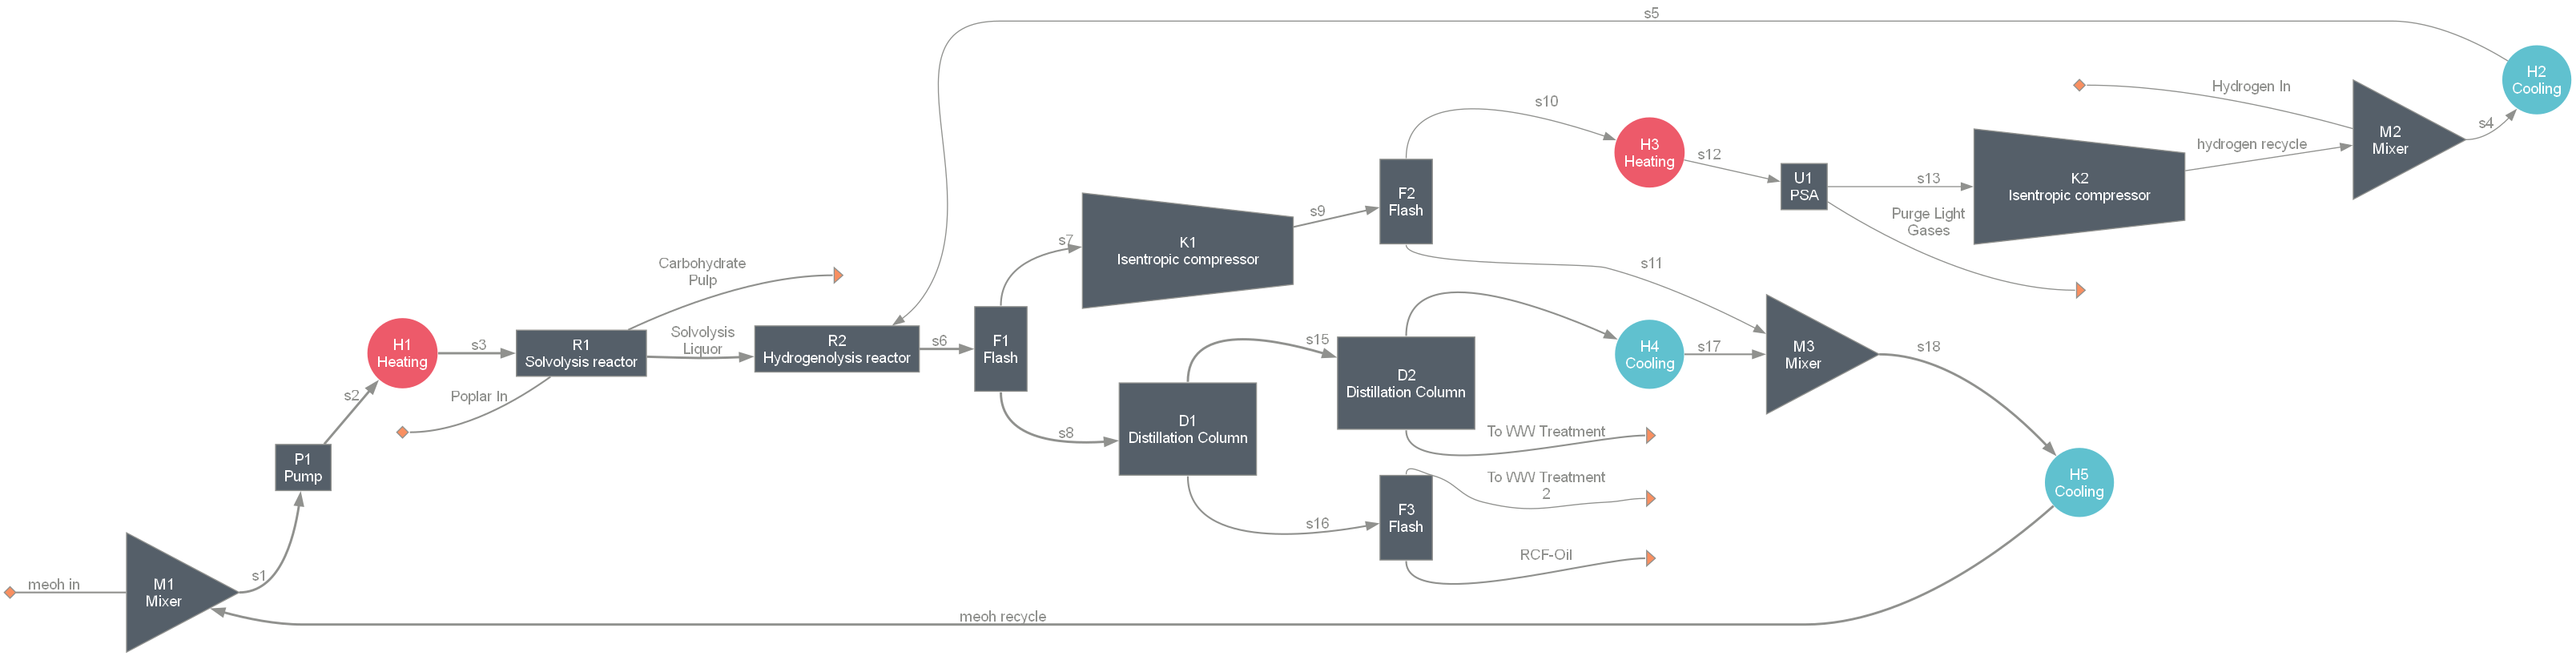

In [52]:
rcf_system.diagram(format = 'png')

In [ ]:
# rcf_system.diagram(file = 'rcfv6', format = 'png')